<a href="https://colab.research.google.com/github/RebeccaRoberts/ALBU_notebooks/blob/master/VMP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

VMP Code

Upload the data set to sample_data: https://www.kaggle.com/gpreda/covid19-tweets

In [ ]:
import numpy as np
from scipy.special import digamma
from scipy import stats
import copy

def get_top_words_in_topics(topn=50, dictionary=None, words_in_topics_ndarray=None,simlda=False):
    """
    Function to get LDA top N words in each topic from emdwlda topics

    Parameters:
    ----------
    topn : Top number of words in a topic
    dictionary : Dictionary originally read in from vocab file that was created from Gensim dictionary
    words_in_topics :
    Returns:
    -------
    words_in_topics_list_result: list of ranked top N words from highest to lowest probability per topic [["word1", "word2"],["word1a", "word2a"]]
    """

    components = []
    for topic in words_in_topics_ndarray:
        topic_tuples = []

        for word_id, confidence in enumerate(topic):
            if simlda:
                if word_id in dictionary:
                    topic_tuples.append((confidence, word_id))
            else:
                if word_id in dictionary:
                    topic_tuples.append((confidence, dictionary[word_id]))

        components.append(topic_tuples)
    sorted_components = []
    for i, component in enumerate(components):
        sorted_component = sorted(component, key=lambda x: x[0], reverse=True)
        sorted_components.append(sorted_component)

    words_in_topics_list_result = []
    for component in sorted_components:
        words_in_topics_list_result.append([x[1] for x in component][0:topn])

    return words_in_topics_list_result

def convert_texts_for_vmp_indices(texts, dictionary):
    # convert to format for VMP (new)
    # I wrote this function yesterday to make it work for any corpora: convert_texts_for_vmp_indices
    dictionary_vmp = []
    corpus_vmp = []
    for text in texts:
        doc = []
        for word in text:
            ind = dictionary.token2id[word]
            if int(ind) not in dictionary_vmp:
                dictionary_vmp.append(int(ind))
            doc.append(int(ind))
        corpus_vmp.append(doc)
    return corpus_vmp, dictionary_vmp

def convert_dict_to_list_for_word_topic_dist(word_topic_kl_dict):
    words_in_topics_ndarray = []
    for topic in word_topic_kl_dict.values():
        words_in_topics_ndarray.append(topic)
    return np.array(words_in_topics_ndarray)

# ++++++++++++++++++++++++++++++++++++++++
# +++ The actual VMP code itself +++++++++
# ++++++++++++++++++++++++++++++++++++++++

def create_topic_word_dirs(K=None, V=None, prior=0.1, noise_variance=0.001):
    topic_word_list = []
    for k in range(K):
        noisy_vector = np.ones(V) + np.random.normal(0, noise_variance, V)
        topic_word_list.append(noisy_vector* prior)

    return np.array(topic_word_list)

def create_doc_topic_list_dirs(M=None, K=None, prior=0.1):
    doc_topic_list = []
    for d in range(M):
        doc_topic_list.append(np.ones(K) * prior)
    return np.array(doc_topic_list)

def create_word_give_topic_cat(K=None, V=None):
    word_given_topic_cat = []
    for k in range(K):
        word_given_topic_cat.append(np.ones(V) * (1 / V))
    return np.array(word_given_topic_cat)

def create_topic_given_doc_cat(M=None, K=None):
    topic_given_doc_cat = []
    for n in range(M):
        topic_given_doc_cat.append(np.ones(K) * (1 / K))
    return np.array(topic_given_doc_cat)

def initialize_graph(M=None, N=None, K=None, V=None, doc_prior=None, topic_prior=None, noise_variance=None):
    topic_word_list = create_topic_word_dirs(K=K, V=V, prior=topic_prior, noise_variance=noise_variance)
    word_given_topic_cat = create_word_give_topic_cat(K=K, V=V)
    topic_given_doc_cat = create_topic_given_doc_cat(M=M, K=K)
    doc_topic_list = create_doc_topic_list_dirs(M=M, K=K, prior=doc_prior)
    return topic_word_list, word_given_topic_cat, topic_given_doc_cat, doc_topic_list

def run_vmp_lda_one_by_one(corpus=None, dictionary=None, K=7, doc_prior=0.5, topic_prior=0.5, noise_variance=0.0001,
                           epochs=100, true_message=True, words_in_topics_ndarray_original=None):
    M = len(corpus)
    N = len(corpus[0])
    V = len(set(dictionary)) + 1

    topic_word_ndarray, word_given_topic_cat, topic_given_doc_cat, doc_topic_array = initialize_graph(M=M, N=N, K=K, V=V, doc_prior=doc_prior, topic_prior=topic_prior,
                                                                                                  noise_variance=noise_variance)

    topic_word_ndarray_prior = create_topic_word_dirs(K=K, V=V, prior=topic_prior, noise_variance=0)
    doc_topic_array_prior = copy.deepcopy(doc_topic_array)
    topic_given_doc_cat_mat = []
    word_given_topic_cat_mat = []
    for m in range(M):
        word_given_topic_cat_list = []
        topic_given_doc_cat_list = []
        for n in range(len(corpus[m])):
            word_given_topic_cat_list.append(word_given_topic_cat)
            topic_given_doc_cat_list.append(topic_given_doc_cat)
        word_given_topic_cat_mat.append(word_given_topic_cat_list)
        topic_given_doc_cat_mat.append(topic_given_doc_cat_list)
    topic_given_doc_cat_mat = np.array(topic_given_doc_cat_mat)
    word_given_topic_cat_mat = np.array(word_given_topic_cat_mat)

    previous_topic_word_ndarray = copy.deepcopy(topic_word_ndarray)
    previous_doc_topic_array = copy.deepcopy(doc_topic_array)
    kl_list = []
    previous_doc_topic_array_list = []
    previous_topic_word_ndarray_list = []

    for epoc in range(epochs):
        for m in range(M):
            # ++++++++++++++++++++++++
            # +++ forward sweep +++++
            # +++++++++++++++++++++++
            for n in range(len(corpus[m])):
                # from topic-word dir to word-topic categorical 
                for k in range(K):
                    if true_message:
                        # adapted VMP message from dirichlet psudo-counts 
                        message_from_topic_word_dir = previous_topic_word_ndarray[k]/np.sum(previous_topic_word_ndarray[k])
                    else:
                        # proper VMP message from dirichlet psudo-counts
                        message_from_topic_word_dir = np.exp(digamma(previous_topic_word_ndarray[k]) -
                                             digamma(np.sum(previous_topic_word_ndarray[k])))
                        # normalise
                        message_from_topic_word_dir = message_from_topic_word_dir / np.sum(message_from_topic_word_dir)

                    # (1) update the word given topic matrix (parent to child) 
                    # print(len(message_from_topic_word_dir),len(corpus[m]),m,n,k)
                    word_given_topic_cat_mat[m][n][k] = message_from_topic_word_dir  # no mixing, just insert

                topic_given_doc_list_mn = []
                for k in range(K):
                    # select the word index corpus[m][n] only and make a list of word probs for that word in each topic (get the slice)
                    topic_given_doc_list_mn.append(word_given_topic_cat_mat[m][n][k][corpus[m][n]])

                # scale the word probabilities for word at index corpus[m][n] over all topics
                message_from_word_given_topic_cat_mat = topic_given_doc_list_mn / np.sum(topic_given_doc_list_mn)  # normalise over K

                # (2) calculate message to document topic dirichlet (child to parent) 
                updated_doc_topic_proportions = topic_given_doc_cat_mat[m][n][m] * message_from_word_given_topic_cat_mat  # we mix at this node

                # normalize
                approximate_update_message_to_dirichlet = updated_doc_topic_proportions/np.sum(updated_doc_topic_proportions)

                # (3) update dirichlet counts by adding new document topic proportions (child to parent)
                doc_topic_array[m] += approximate_update_message_to_dirichlet/np.sum(approximate_update_message_to_dirichlet) # mix by adding to \alpha hyperparameters
                
            # ++++++++++++++++++++++++
            # +++ backward sweep +++++
            # ++++++++++++++++++++++++

            for n in range(len(corpus[m])):
                # from topic-doc dir to topic-doc categorical
                if true_message:
                    message_from_doc_topic_dir =doc_topic_array[m]/np.sum(doc_topic_array[m])
                else:
                    message_from_doc_topic_dir = np.exp(digamma(doc_topic_array[m]) -
                                         digamma(np.sum(doc_topic_array[m])))
                    # normalise
                    message_from_doc_topic_dir = message_from_doc_topic_dir / np.sum(message_from_doc_topic_dir)

                # (4) update the doc given topic matrix (parent to child)
                # print(m,n)
                topic_given_doc_cat_mat[m][n][m] = message_from_doc_topic_dir # no mixing, just insert
 

                # (5) + (6a) from topic-doc categorical to topic-word dir 
                topic_given_word_probs = np.ones(K)
                for k in range(K):
                    # a. select the word index corpus[m][n]
                    # b. multiply by the proportion of that topic within that document
                    # This gives a list of word probs for that word in each topic so we can update the Dirichelts
                    # NB: we arent updating word given topic matrix since it will anyways get replaced
                    # in the following epoch in the oposite direction. 
                    # The W node is always a child! (parent to child)
                    topic_given_word_probs[k] = word_given_topic_cat_mat[m][n][k][corpus[m][n]] * \
                                                topic_given_doc_cat_mat[m][n][m][k]  # this looks like mixing but doing this for the dir update

                # normalise over K                              
                message_to_word_topic_dirichlet = (topic_given_word_probs / np.sum(topic_given_word_probs))

                # updating the topic-word dir (the calculated message is done in 6a)
                for k in range(K):
                    topic_word_ndarray[k][corpus[m][n]] += message_to_word_topic_dirichlet[k]

            previous_doc_topic_array_list.append(doc_topic_array)
            previous_topic_word_ndarray_list.append(topic_word_ndarray)


        previous_topic_word_ndarray = copy.deepcopy(topic_word_ndarray)
        topic_word_ndarray = copy.deepcopy(topic_word_ndarray_prior)

        previous_doc_topic_array = copy.deepcopy(doc_topic_array)
        doc_topic_array = copy.deepcopy(doc_topic_array_prior)

    return previous_doc_topic_array, previous_topic_word_ndarray, previous_doc_topic_array_list, previous_topic_word_ndarray_list



Some preprocessy stuff. Many ways to do this, an this is code I wrote a long time ago, stolen bits from Gensim etc etc. 


In [ ]:
import os
from subprocess import run
import gzip

from gensim.utils import simple_preprocess
from gensim.models import Phrases
from gensim.corpora import Dictionary
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models.coherencemodel import CoherenceModel



def build_texts(file_name=None, raw_texts=None):
    """
    Build tokenized texts from file name or raw_texts

    Parameters:
    ----------
    file_name: str
            File to be read
    raw_texts: list
            Raw texts with no pre-processing

    Returns:
    -------
    yields generator: if cast to list, is list of text each containing lists of words
    """

    if file_name:
        with open(file_name) as f:
            for line in f:
                yield simple_preprocess(line, deacc=True, min_len=3, max_len=50)
    elif raw_texts:
        for doc in raw_texts:
            # print(doc)
            # print()
            yield simple_preprocess(doc, deacc=True, min_len=3,  max_len=50)


def process_texts(texts, additional_stopwords=None, stop=True, lemmatize=True, collocation=False):
    """
    Function to process texts. Following are the steps we take:

    1. Stopword Removal.
    2. Lemmatization
    3. Collocation detection.

    Parameters:
    ----------
    texts: texts with very basic processing (tokenized)
    additional_stopwords: extra stopwords to remove
    stop: True or False
    lemmatize: True or False
    collocation: True or False

    Returns:
    -------
    texts: Pre-processed tokenized texts.
    """

    if collocation:
        bigram = Phrases(texts)
    if stop:
        nltk.download('stopwords')
        if not additional_stopwords:
            additional_stopwords = []
        stops = set(stopwords.words('english') + additional_stopwords)
    if lemmatize:
        nltk.download('wordnet')
        lemmatizer = WordNetLemmatizer()

    # remove stopwords
    if stop:
        texts = [[word for word in doc if word not in stops] for doc in texts]
    # convert words in different forms to same root word (like stemming)
    if lemmatize:
        texts = [[lemmatizer.lemmatize(word=word, pos='n') for word in doc] for doc in texts]
    # remove stopwords again in case more popped up after lematizing
    if stop:
        texts = [[word for word in doc if word not in stops] for doc in texts]
    if collocation:
        texts = [bigram[doc] for doc in texts]


    return texts
    
def raw_to_corpus_dict_texts(texts=None, filename=None, additional_stopwords=None):
    """
    Generate corpus (bag of words), dictionary and tokenized texts from filename or unprocessed texts

    Parameters:
    ----------
    texts: texts with very basic processing (tokenized)
    fname: name of file to get raw texts
    additional_stopwords: extra stopwords to remove

    Returns:
    -------
    texts: Pre-processed tokenized texts.
    corpus: bag of words corpus
    dictionary: gensim dictionary to link IDs to actual words

    """
    # for text in texts:
    #         print(text)

    if texts:
        texts = list(texts)
    elif filename:
        texts = list(build_texts(filename))
    else:
        raise ValueError("Requires either file_name or raw_tests.")
    texts = process_texts(texts, additional_stopwords=additional_stopwords)

    all_tokens = sum(texts, [])
    tokens_few = set(word for word in set(all_tokens) if all_tokens.count(word) < 3)
    texts = [[word for word in text if word not in tokens_few]
            for text in texts]
  
    corpus, dictionary = processed_to_corpus_dict(texts)


    return texts, corpus, dictionary

def processed_to_corpus_dict(preprocessed):
    """
    Build corpus (bag of words) and dictionary from from preprocessed texts (tokenized)

    Parameters:
    ----------
    preprocessed: tokenized texts

    Returns:
    -------
    corpus: bag of words corpus
    dictionary: gensim dictionary to link IDs to actual words
    """
    dictionary = Dictionary()
    corpus = [dictionary.doc2bow(doc, allow_update=True) for doc in preprocessed]
    dictionary.compactify() # remove gaps in id sequence after words that were removed
    return corpus, dictionary

def evaluate_topics_coherence_over_topic_range(texts=None, corpus=None, dictionary=None, topic_range=None, top_n=None, lda_topic_dict=None):
    """
    Function to display num_topics - LDA graph using c_v and u_mass coherence

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    topic_range : list of number of topics
    lda_model_dict : dictionary of LDA topic models for each number of topics

    Returns:
    -------
    c_v : Coherence values corresponding to the LDA model with respective number of topics using c_v
    u_m : Coherence values corresponding to the LDA model with respective number of topics using u_mass
    c_uci : Coherence values corresponding to the LDA model with respective number of topics using c_uci
    c_cnpmi : Coherence values corresponding to the LDA model with respective number of topics using c_cnpmi
    """
    c_v = []
    u_m = []
    c_uci = []
    c_npmi = []

    if topic_range is None:
        topic_range = list(lda_topic_dict.keys())

    if top_n is None:
        top_n = len(lda_topic_dict[topic_range[0]])

    if lda_topic_dict and texts and corpus and dictionary:
        for num_topics in topic_range:
            cm = CoherenceModel(topics=lda_topic_dict[num_topics], texts=texts, dictionary=dictionary, coherence='c_v', topn=top_n)
            cmu = CoherenceModel(topics=lda_topic_dict[num_topics], texts=texts, dictionary=dictionary, coherence='u_mass', topn=top_n)
            cuci = CoherenceModel(topics=lda_topic_dict[num_topics], texts=texts, dictionary=dictionary, coherence='c_uci', topn=top_n)
            cnpmi = CoherenceModel(topics=lda_topic_dict[num_topics], texts=texts, dictionary=dictionary, coherence='c_npmi', topn=top_n)

            c_v.append(cm.get_coherence())
            u_m.append(cmu.get_coherence())
            c_uci.append(cuci.get_coherence())
            c_npmi.append(cnpmi.get_coherence())
    else:
        raise ValueError("Requires lda_topic_dict, texts, corpus and dictionary")

    return {"c_v": c_v, "u_m": u_m, "c_uci": c_uci, "c_npmi": c_npmi}

def plot_coherence(coh_dict,k_range,label):
  for measure in coh_dict.keys():
      plt.figure()
      x = k_range
      plt.plot(x, coh_dict[measure],label='VMP')
      plt.xlabel("Number of topics")
      plt.ylabel("Coherence score: " + measure)
      plt.legend(loc='best')
      plt.grid()
    
      plt.show()

In [ ]:
from gensim.models.ldamodel import LdaModel

def gensim_lda(corpus=None, dictionary=None, k=7, default_alphas_topic_doc="auto", default_betas_word_topic="auto", run_type="online", epochs=250,
               batch_size=1, from_simlda=False):

    np.random.seed(1)  # setting random seed to get the same results each time.

    if run_type is "batch":
        model = LdaModel(corpus, id2word=dictionary, num_topics=k, alpha=default_alphas_topic_doc, eta=default_betas_word_topic, update_every=0, passes=epochs)
    else:
        model = LdaModel(corpus, id2word=dictionary, num_topics=k, alpha=default_alphas_topic_doc, eta=default_betas_word_topic, update_every=batch_size,
                         passes=epochs)

    words_in_topics_dict_result = {}
    topics_tup = model.get_topics()

    top_n = topics_tup.shape[1]
    for i in range(k):
        single_topic = model.get_topic_terms(i, topn=top_n)
        words_in_topics_dict_result[i] = []

        if from_simlda:
            for d in range(top_n):
                found = False
                for tup in single_topic:
                    if dictionary.id2token[tup[0]] == str(d):
                        words_in_topics_dict_result[i].append(tup[1])
                        found = True
                if not found:
                    words_in_topics_dict_result[i].append(0.0)
        else:
            for word in dictionary:
                found = False
                for tup in single_topic:
                    if tup[0] == word:
                        words_in_topics_dict_result[i].append(tup[1])
                        found = True
                if not found:
                    words_in_topics_dict_result[i].append(0.0)

    return words_in_topics_dict_result

How I process a corpus: this is the covid tweets example, but basically 

In [ ]:

import timeit
import time
import string
import pandas as pd
import re
import nltk

from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords

from gensim.parsing.preprocessing import strip_multiple_whitespaces, strip_numeric, split_alphanum, strip_non_alphanum
from matplotlib import pyplot as plt
# use the first time
# nltk.download('punkt')
# nltk.download('stopwords')

regex = re.compile('[^a-zA-Z]')

# number of tweeets to use
num_tweets = 1000 # make bigger for real use case
# covid19_tweets = pd.read_csv("sample_data/covid19_tweets.csv")
covid19_tweets = pd.read_csv("/content/drive/MyDrive/datasets/covid19_tweets.csv")
tweets_list = list(covid19_tweets['text'])[0:num_tweets]


# General processing
doc_list = tweets_list
new_doc_list = []

for i, doc in enumerate(doc_list):
    s = regex.sub(" ", str(doc))
    ps = strip_multiple_whitespaces(strip_numeric(split_alphanum(strip_non_alphanum(s))))
    new_doc_list.append(ps)

raw_texts = build_texts(raw_texts=new_doc_list)

# covid related but can add for specific corpus
texts, _, _ = raw_to_corpus_dict_texts(texts=raw_texts,additional_stopwords=["http","cov","covid","amp", "july"])

decent_texts = []
for text in texts:
    decent_text = []
    for word in text:  
        if len(word)>2:                   # get rid of really short words
            decent_text.append(word)

    if len(decent_text) > 3:              # docs with 3 words and less dont add much value in LDA
      decent_texts.append(decent_text)

texts = decent_texts
corpus, dictionary = processed_to_corpus_dict(texts)
corpus_vmp, dictionary_ind = convert_texts_for_vmp_indices(texts, dictionary)   # convert to word indices and update dictionary

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
true_messge = False
k_range = range(3,8)

topn = 20
doc_prior = 0.1
topic_prior = 0.1
epochs = 120

# ++++++++++++++++++++++++
# +++ Run VMP +++++
# ++++++++++++++++++++++++

lda_topic_dict_VMP = {}

startelapsed = time.time()

for k in k_range:
  doc_topic_array, topic_word_ndarray, doc_topic_array_list_list_vmp, topic_word_ndarray_list_list_vmp = run_vmp_lda_one_by_one(corpus=corpus_vmp,
                                                                          dictionary=dictionary_ind,
                                                                          K=k,
                                                                          doc_prior=doc_prior,
                                                                          topic_prior=topic_prior,
                                                                          noise_variance=0.001,
                                                                          epochs=epochs,
                                                                          true_message=true_messge)
  lda_topic_dict_VMP[k] = get_top_words_in_topics(topn=topn, dictionary=dictionary, words_in_topics_ndarray=topic_word_ndarray)

endelapsed = time.time()

print("VMP elapsed time:", endelapsed - startelapsed)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


VMP elapsed time: 212.75943851470947


In [ ]:

# ++++++++++++++++++++++++
# +++ Run VB +++++
# ++++++++++++++++++++++++

doc_prior = 0.1
topic_prior = 0.1

startelapsed = time.time()

lda_topic_dict_VB = {}

for k in k_range:
      topic_word_dict = gensim_lda(corpus=corpus, dictionary=dictionary,
             k=k,
             default_alphas_topic_doc=doc_prior,
             default_betas_word_topic=topic_prior,
             run_type="batch", epochs=epochs, from_simlda=False) # batch is for non-online version, I use batch as full corpus in one batch basically

      lda_topic_dict_VB[k] = get_top_words_in_topics(topn=topn, dictionary=dictionary, words_in_topics_ndarray=convert_dict_to_list_for_word_topic_dist(topic_word_dict))

endelapsed = time.time()

print("VB elapsed time:", endelapsed - startelapsed)

VB elapsed time: 47.24035358428955


In [ ]:
coh_dict_VMP = evaluate_topics_coherence_over_topic_range(texts=texts, 
                                                           corpus=corpus, 
                                                           dictionary=dictionary,
                                                           topic_range=k_range, 
                                                           top_n=topn, 
                                                           lda_topic_dict=lda_topic_dict_VMP)


coh_dict_VB = evaluate_topics_coherence_over_topic_range(texts=texts, 
                                                           corpus=corpus, 
                                                           dictionary=dictionary,
                                                           topic_range=k_range, 
                                                           top_n=topn, 
                                                           lda_topic_dict=lda_topic_dict_VB)

************* VMP ************


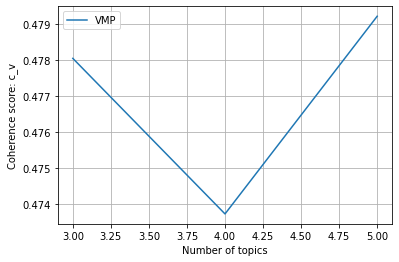

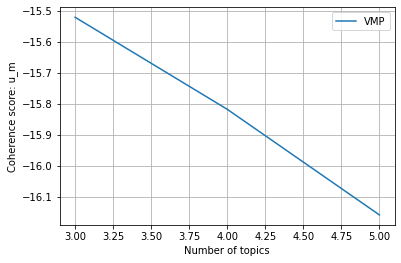

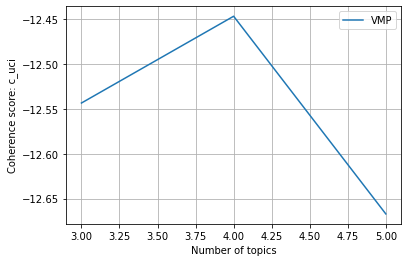

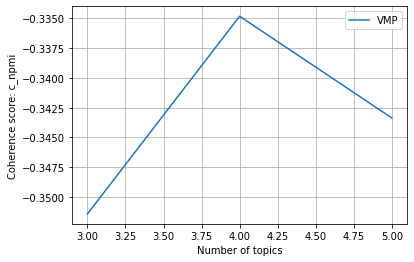

************* VB ************


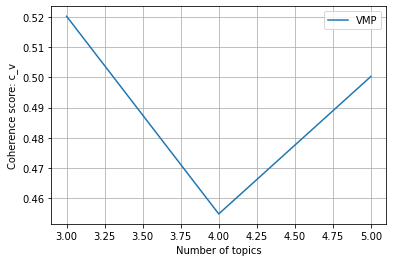

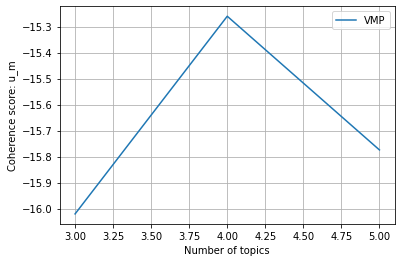

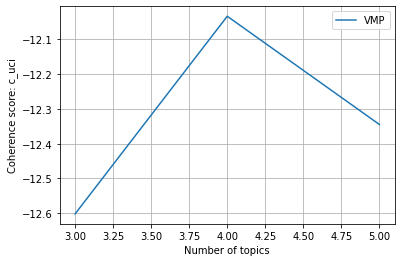

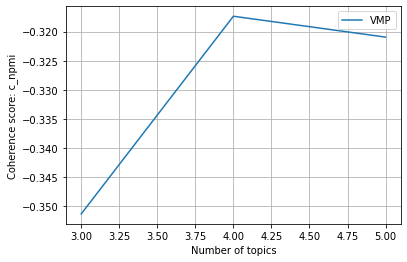

In [ ]:
print("************* VMP ************")
plot_coherence(coh_dict_VMP,k_range,"VMP")

print("************* VB ************")
plot_coherence(coh_dict_VB,k_range,"VB")




In [ ]:
import numpy as np
from scipy.special import digamma

previous_topic_word_ndarray = [0.5,0.5,0.5,0.5]
for k in range(len(previous_topic_word_ndarray)):
  message_from_topic_word_dir = np.exp(digamma(previous_topic_word_ndarray[k]))# -digamma(np.sum(previous_topic_word_ndarray[k])))
  print("1",message_from_topic_word_dir)
  message_from_topic_word_dir = message_from_topic_word_dir / np.sum(message_from_topic_word_dir)
  print("2",message_from_topic_word_dir)

1 0.14036487089172128
2 1.0
1 0.14036487089172128
2 1.0
1 0.14036487089172128
2 1.0
1 0.14036487089172128
2 1.0
